<p style="font-size: 45px; text-align: center;"><b>Machine Learning in Finance II - final project</b></p>
<p style="font-size: 35px; text-align: center;"><b>Forecasting delays in delivery time - Brazilian E-commerce</b></p>
<p style="font-size: 20px; text-align: center;"><b>XGBoost - choosing the best model</b></p>

Author: Jakub Pyszniak

Notebook 3

# Analysis overview

> **In this section we will choose the best XGBoost (regressor) model to predict order delays**

> **We perform the necessary Cross-Validation**

# Libraries

In [76]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from scipy import stats
import math
import time
from scipy.stats import randint, uniform, loguniform
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

# Visual set-up
pd.set_option("display.max_columns", 60)

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# Loading data & choosing the best features

We can use the feature ranking from earlier to limit our feature ("X") set size from 30+ to 10 or 15 best

In [24]:
# These data will be used for CV and choosing the best models
df_train = pd.read_csv("4.train_and_test/df_train.csv")

# We will use this set to test the forecasting power of our best models (final comparisons)
df_test = pd.read_csv("4.train_and_test/df_test.csv")

# Our feature ranking dataset
fr = pd.read_excel("3.feature_ranking/feature_ranking.xlsx")

In [25]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   delay_days                     73180 non-null  float64
 1   order_item_id                  73180 non-null  int64  
 2   total_price                    73180 non-null  float64
 3   total_freight                  73180 non-null  float64
 4   order_value_check              73180 non-null  float64
 5   is_payment_sequential_1        73180 non-null  int64  
 6   payment_type_boleto            73180 non-null  int64  
 7   payment_type_credit_card       73180 non-null  int64  
 8   payment_type_debit_card        73180 non-null  int64  
 9   payment_type_voucher           73180 non-null  int64  
 10  installments_boleto            73180 non-null  int64  
 11  installments_credit_card       73180 non-null  int64  
 12  installments_debit_card        73180 non-null 

,delay_days,order_item_id,total_price,total_freight,order_value_check,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,installments_boleto,installments_credit_card,installments_debit_card,installments_voucher,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state,customer_state,cust_sell_same_state,customer_lat,customer_lng,seller_lat,seller_lng,cust_sell_distance_km,order_purchase_month,order_delivery_month,order_purchase_dow,order_delivery_dow,order_estimate_dow
0,-21.0,1,19.99,14.10,34.09,1,0,1,0,0,0,1,0,0,48.0,575.0,1,100.0,20.0,15.0,15.0,43,21,18,0,-22.761992,-43.450873,-23.665703,-46.518082,329.149657,6,6,5,0,0
1,-4.0,1,72.90,19.70,92.60,1,0,1,0,0,0,1,0,0,37.0,360.0,1,650.0,45.0,15.0,25.0,67,14,25,0,-21.679558,-49.762053,-23.179392,-50.634922,189.372236,8,8,0,3,0
2,-38.0,1,50.90,15.57,66.47,1,0,1,0,0,0,1,0,0,60.0,473.0,1,600.0,30.0,4.0,20.0,39,21,18,0,-22.449744,-43.474330,-21.766477,-48.831547,557.068979,2,2,3,4,0
3,-8.0,1,199.90,14.23,214.13,1,0,1,0,0,0,5,0,0,60.0,233.0,1,2600.0,41.0,8.0,36.0,7,21,25,1,-23.640572,-46.570773,-22.716839,-47.657366,151.282904,6,6,0,2,3
4,-12.0,2,44.00,35.26,79.26,1,0,1,0,0,0,7,0,0,58.0,1623.0,1,200.0,26.0,10.0,22.0,7,5,18,0,-22.983577,-43.220723,-16.692331,-49.268016,942.794225,3,3,4,2,0


In [26]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   delay_days                     18295 non-null  float64
 1   order_item_id                  18295 non-null  int64  
 2   total_price                    18295 non-null  float64
 3   total_freight                  18295 non-null  float64
 4   order_value_check              18295 non-null  float64
 5   is_payment_sequential_1        18295 non-null  int64  
 6   payment_type_boleto            18295 non-null  int64  
 7   payment_type_credit_card       18295 non-null  int64  
 8   payment_type_debit_card        18295 non-null  int64  
 9   payment_type_voucher           18295 non-null  int64  
 10  installments_boleto            18295 non-null  int64  
 11  installments_credit_card       18295 non-null  int64  
 12  installments_debit_card        18295 non-null 

,delay_days,order_item_id,total_price,total_freight,order_value_check,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,installments_boleto,installments_credit_card,installments_debit_card,installments_voucher,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state,customer_state,cust_sell_same_state,customer_lat,customer_lng,seller_lat,seller_lng,cust_sell_distance_km,order_purchase_month,order_delivery_month,order_purchase_dow,order_delivery_dow,order_estimate_dow
0,-15.0,1,108.0,16.52,124.52,1,0,1,0,0,0,1,0,0,58.0,3006.0,2,1000.0,53.0,8.0,18.0,72,15,10,0,-21.248980,-44.998179,-22.874599,-43.477731,239.212282,2,2,5,3,4
1,-2.0,1,78.0,7.80,85.80,1,0,1,0,0,0,2,0,0,59.0,319.0,4,250.0,16.0,2.0,20.0,72,21,25,1,-23.657047,-46.774874,-23.651115,-46.755211,2.108617,11,11,4,1,3
2,-19.0,1,199.9,15.15,215.05,1,0,1,0,0,0,5,0,0,55.0,623.0,1,337.0,16.0,13.0,13.0,72,21,18,0,-22.704280,-43.571287,-22.828655,-47.267296,379.200398,6,6,3,2,0
3,-17.0,1,69.0,19.45,88.45,1,0,1,0,0,0,6,0,0,51.0,324.0,1,900.0,42.0,8.0,37.0,7,21,18,0,-22.747569,-43.488349,-21.766477,-48.831547,560.549267,6,6,3,0,3
4,-5.0,1,44.9,9.42,54.32,1,1,0,0,0,1,0,0,0,51.0,1118.0,5,400.0,18.0,8.0,14.0,49,21,25,1,-23.663579,-46.617176,-23.198860,-47.293346,86.193580,3,3,3,3,1


In [27]:
fr.rename(columns={"Unnamed: 0": "feature"}, inplace=True)

fr = fr.sort_values(by=["boruta_rank","mi_score"], ascending=[True, False])

fr.info()
fr.head(40)

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 2 to 11
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   feature      34 non-null     object 
 1   mi_score     34 non-null     float64
 2   boruta_rank  34 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ KB


,feature,mi_score,boruta_rank
2,total_freight,0.071483,1
29,order_purchase_month,0.067143,1
30,order_delivery_month,0.063950,1
27,seller_lng,0.057679,1
28,cust_sell_distance_km,0.052569,1
24,customer_lat,0.046624,1
25,customer_lng,0.044898,1
23,cust_sell_same_state,0.043066,1
21,seller_state,0.020188,1
13,product_name_length,0.003299,1


In [28]:
fr = fr.set_index("feature")

We will create arrays with the best features so that we can pick them later from our dataframes

In [40]:
br10_feat = fr.iloc[0:10].index.tolist()
print("10 best:\n", br10_feat)

br15_feat = fr.iloc[0:15].index.tolist()
print("15 best:\n", br15_feat)

br20_feat = fr.iloc[0:20].index.tolist()
print("20 best:\n", br20_feat)

br25_feat = fr.iloc[0:25].index.tolist()
print("25 best:\n", br25_feat)

br30_feat = fr.iloc[0:30].index.tolist()
print("30 best:\n", br30_feat)

10 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_month', 'seller_lng', 'cust_sell_distance_km', 'customer_lat', 'customer_lng', 'cust_sell_same_state', 'seller_state', 'product_name_length']
15 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_month', 'seller_lng', 'cust_sell_distance_km', 'customer_lat', 'customer_lng', 'cust_sell_same_state', 'seller_state', 'product_name_length', 'product_width_cm', 'order_estimate_dow', 'product_weight_g', 'seller_lat', 'product_height_cm']
20 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_month', 'seller_lng', 'cust_sell_distance_km', 'customer_lat', 'customer_lng', 'cust_sell_same_state', 'seller_state', 'product_name_length', 'product_width_cm', 'order_estimate_dow', 'product_weight_g', 'seller_lat', 'product_height_cm', 'order_value_check', 'customer_state', 'product_description_length', 'total_price', 'order_delivery_dow']
25 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_mo

## X and y test/train

In [41]:
# build X / y splits using only the selected features

X10_train = df_train.loc[:, br10_feat].copy()
X15_train = df_train.loc[:, br15_feat].copy()
X20_train = df_train.loc[:, br20_feat].copy()
X25_train = df_train.loc[:, br25_feat].copy()
X30_train = df_train.loc[:, br30_feat].copy()
y_train = df_train.loc[:, "delay_days"].copy()

X10_test  = df_test.loc[:, br10_feat].copy()
X15_test  = df_test.loc[:, br15_feat].copy()
X20_test  = df_test.loc[:, br20_feat].copy()
X25_test  = df_test.loc[:, br25_feat].copy()
X30_test  = df_test.loc[:, br30_feat].copy()
y_test  = df_test.loc[:, "delay_days"].copy()

In [42]:
X10_train.info(), X15_train.info(), X20_train.info(), X25_train.info(), X30_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_freight          73180 non-null  float64
 1   order_purchase_month   73180 non-null  int64  
 2   order_delivery_month   73180 non-null  int64  
 3   seller_lng             73180 non-null  float64
 4   cust_sell_distance_km  73180 non-null  float64
 5   customer_lat           73180 non-null  float64
 6   customer_lng           73180 non-null  float64
 7   cust_sell_same_state   73180 non-null  int64  
 8   seller_state           73180 non-null  int64  
 9   product_name_length    73180 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 5.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0  

(None, None, None, None, None)

In [43]:
X10_test.info(), X15_test.info(), X20_test.info(), X25_test.info(), X30_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_freight          18295 non-null  float64
 1   order_purchase_month   18295 non-null  int64  
 2   order_delivery_month   18295 non-null  int64  
 3   seller_lng             18295 non-null  float64
 4   cust_sell_distance_km  18295 non-null  float64
 5   customer_lat           18295 non-null  float64
 6   customer_lng           18295 non-null  float64
 7   cust_sell_same_state   18295 non-null  int64  
 8   seller_state           18295 non-null  int64  
 9   product_name_length    18295 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 1.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0  

(None, None, None, None, None)

In [33]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 73180 entries, 0 to 73179
Series name: delay_days
Non-Null Count  Dtype  
--------------  -----  
73180 non-null  float64
dtypes: float64(1)
memory usage: 571.8 KB


In [34]:
y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 18295 entries, 0 to 18294
Series name: delay_days
Non-Null Count  Dtype  
--------------  -----  
18295 non-null  float64
dtypes: float64(1)
memory usage: 143.1 KB


# Model selection

A standard GridSearchCV might be too taxing for an XGBoost model if we want to try out a variety of hyperparameters. We will use RandomizedSearchCV as a basis.

> Our RandomizedSearchCV set-up

In [ ]:
def cv_my_random_xgb(
    X_train, y_train, X_test, y_test,
    param_distributions=None,
    n_iter=60,
    cv=5,
    random_state=42,
    show_results=False
):
    # ----------------------------
    # 0) Start a high-resolution timer so we can report total runtime at the end
    # ----------------------------
    start = time.perf_counter()

    # ----------------------------
    # 1) Define the cross-validation splitter
    #    - shuffle=True helps avoid fold bias if your rows are ordered in any way
    #           - they already should be shuffled but we use this as a precaution
    # ----------------------------
    cv_split = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    # ----------------------------
    # 2) Define the base XGBoost model (regression)
    #    - objective="reg:squarederror" is standard for regression RMSE/MAE tasks
    #    - tree_method="hist" tends to be faster on CPU for medium/large datasets
    #       - alternatively we could use "exact" for the original tree method or "approx"
    #       - we want to, however, check out many different HP so we need to make sure models run fast
    #    - n_jobs=-1 uses all CPU cores
    #    - verbosity=0 silences XGBoost training output
    # ----------------------------
    xgb = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist", 
        n_jobs=-1,
        random_state=random_state,
        verbosity=0
    )

    # ----------------------------
    # 3) Define hyperparameter search space ("param_distributions")
    #    If user does not pass one, we use a reasonable default.
    #
    #    NOTE: 1) RandomizedSearchCV will sample n_iter random combinations from these distributions.
    #    NOTE: 2) We can input values directly as arrays or we can assign distributions to sample from
    # ----------------------------
    if param_distributions is None:
        param_distributions = {
            # Number of boosting rounds (trees). Base learner is a tree
            #"n_estimators": randint(100, 1000),

            # Step size shrinkage. Log-uniform is typical since good values vary by orders of magnitude.
            "learning_rate": loguniform(0.01, 0.2), # generally, we are looking for small values

            # Controls tree complexity (how deep they go)
            "max_depth": randint(2, 10),

            # Minimum sum of instance weight needed (hessian) in a child to split a node (regularizes tree growth)
            "min_child_weight": loguniform(0.5, 50.0),

            # Row subsampling  - we won't choose all the rows for training each particular tree (regularization + faster training)
            "subsample": uniform(0.6, 0.4),  # from 0.6  to 1.0

            # Column subsampling per tree - similarily we will choose a random percentage of columns (regularization + faster training)
            "colsample_bytree": uniform(0.6, 0.4),  # from 0.6  to 1.0

            # Minimum loss reduction to make a further partition (regularization)
            "gamma": loguniform(1e-8, 5.0),

            # L1 regularization (sparsity)
            "reg_alpha": loguniform(1e-8, 10.0),

            # L2 regularization (weight shrinkage)
            "reg_lambda": loguniform(0.5, 50.0),
        }

    # ----------------------------
    # 4) Set up RandomizedSearchCV
    #    - scoring uses neg_root_mean_squared_error (sklearn convention: higher is better, hence negative)
    #    - cv=cv_split ensures the exact splitter we defined is used
    #    - refit=True refits the best found model on the FULL training set at the end
    # ----------------------------
    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=cv_split,
        refit=True,
        return_train_score=True,
        n_jobs=-1,
        random_state=random_state,
        verbose=0
    )

    # ----------------------------
    # 5) Run hyperparameter tuning on the TRAINING data only
    #    This will internally do:
    #      - sample n_iter parameter combinations
    #      - for each combination, run cross-validation with 'cv' folds
    #      - select the combination with the best mean CV score
    #      - refit the best model on the full X_train/y_train (because refit=True)
    # ----------------------------
    search.fit(X_train, y_train)

    # After fit: best_estimator_ is the refit model trained on the full training set
    best_model = search.best_estimator_

    # ----------------------------
    # 6) Final evaluation on the TEST set (unseen during tuning - obvious but crucial to not forget during CV set-ups)
    # ----------------------------
    y_pred = best_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    # ----------------------------
    # 7) Stop timer and compute elapsed time (for convenience)
    # ----------------------------
    elapsed_sec = time.perf_counter() - start

    # ----------------------------
    # 8) Optional printing (off by default)
    # ----------------------------
    if show_results:
        print("Best params:", search.best_params_)
        print("Best CV RMSE:", -search.best_score_)  # negate because scoring is negative RMSE
        print("TEST RMSE:", rmse)
        print("TEST MAE:", mae)
        print("TEST R²:", r2)
        print(f"Elapsed time: {elapsed_sec:.2f} seconds")

    # ----------------------------
    # 9) Return objects + metrics so you can inspect results later
    # ----------------------------
    return {
        "search": search,                     # full RandomizedSearchCV object (cv_results_, best_params_, etc.)
        "best_model": best_model,             # the refit best estimator trained on full X_train/y_train
        "best_cv_rmse": -search.best_score_,  # best mean CV RMSE (converted back to positive)
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "elapsed_sec": elapsed_sec
    }


**Different features**

In [36]:
param_distributions = {
            #"n_estimators": randint(100, 1000),
            "learning_rate": loguniform(0.01, 0.2), # generally, we are looking for small values
            "max_depth": randint(2, 10),
            "min_child_weight": loguniform(0.5, 50.0),
            "subsample": uniform(0.6, 0.4),  # from 0.6  to 1.0
            "colsample_bytree": uniform(0.6, 0.4),  # from 0.6  to 1.0
            "gamma": loguniform(1e-8, 5.0),
            "reg_alpha": loguniform(1e-8, 10.0),
            "reg_lambda": loguniform(0.5, 50.0),
        }


xgb10vars_RS = cv_my_random_xgb(
    X10_train, y_train, X10_test, y_test,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    show_results=True
)

Best params: {'colsample_bytree': np.float64(0.7580600944007257), 'gamma': np.float64(1.1507412407252788), 'learning_rate': np.float64(0.08834921226320053), 'max_depth': 8, 'min_child_weight': np.float64(0.7515450322528409), 'reg_alpha': np.float64(5.805581976088804e-07), 'reg_lambda': np.float64(0.615778586183301), 'subsample': np.float64(0.7301321323053057)}
Best CV RMSE: 7.487009182548458
TEST RMSE: 7.4092050451679565
TEST MAE: 5.280126977522241
TEST R²: 0.48787752824215913
Elapsed time: 75.19 seconds


In [37]:
# We can access these scores later!

# xgb10vars_RS["search"].best_params_
# xgb10vars_RS["search"].cv_results_
# xgb10vars_RS["search"].best_score_
# xgb10vars_RS["rmse"] # test rmse

In [38]:
xgb15vars_RS = cv_my_random_xgb(
    X15_train, y_train, X15_test, y_test,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    show_results=True
)

Best params: {'colsample_bytree': np.float64(0.7580600944007257), 'gamma': np.float64(1.1507412407252788), 'learning_rate': np.float64(0.08834921226320053), 'max_depth': 8, 'min_child_weight': np.float64(0.7515450322528409), 'reg_alpha': np.float64(5.805581976088804e-07), 'reg_lambda': np.float64(0.615778586183301), 'subsample': np.float64(0.7301321323053057)}
Best CV RMSE: 7.490453146833093
TEST RMSE: 7.36410953908016
TEST MAE: 5.210528632155466
TEST R²: 0.49409253802243436
Elapsed time: 96.15 seconds


In [39]:
xgb20vars_RS = cv_my_random_xgb(
    X20_train, y_train, X20_test, y_test,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    show_results=True
)

Best params: {'colsample_bytree': np.float64(0.7364265404201034), 'gamma': np.float64(9.707396248573825e-08), 'learning_rate': np.float64(0.15960780836641722), 'max_depth': 7, 'min_child_weight': np.float64(12.317960384326298), 'reg_alpha': np.float64(1.1401190340140422e-06), 'reg_lambda': np.float64(1.1191282495204613), 'subsample': np.float64(0.9928673373317742)}
Best CV RMSE: 7.465208324499682
TEST RMSE: 7.3624389130389805
TEST MAE: 5.2090119118120874
TEST R²: 0.4943220528895528
Elapsed time: 116.26 seconds


In [44]:
xgb25vars_RS = cv_my_random_xgb(
    X25_train, y_train, X25_test, y_test,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    show_results=True
)

Best params: {'colsample_bytree': np.float64(0.7364265404201034), 'gamma': np.float64(9.707396248573825e-08), 'learning_rate': np.float64(0.15960780836641722), 'max_depth': 7, 'min_child_weight': np.float64(12.317960384326298), 'reg_alpha': np.float64(1.1401190340140422e-06), 'reg_lambda': np.float64(1.1191282495204613), 'subsample': np.float64(0.9928673373317742)}
Best CV RMSE: 7.505452757448092
TEST RMSE: 7.3346493196987765
TEST MAE: 5.201828870333041
TEST R²: 0.4981322206538722
Elapsed time: 130.07 seconds


TEST RMSE continues to drop but we see a slight increase in Best CV RMSE

In [45]:
xgb30vars_RS = cv_my_random_xgb(
    X30_train, y_train, X30_test, y_test,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    show_results=True
)

Best params: {'colsample_bytree': np.float64(0.7364265404201034), 'gamma': np.float64(9.707396248573825e-08), 'learning_rate': np.float64(0.15960780836641722), 'max_depth': 7, 'min_child_weight': np.float64(12.317960384326298), 'reg_alpha': np.float64(1.1401190340140422e-06), 'reg_lambda': np.float64(1.1191282495204613), 'subsample': np.float64(0.9928673373317742)}
Best CV RMSE: 7.466364582837167
TEST RMSE: 7.353748114938758
TEST MAE: 5.182623955663716
TEST R²: 0.4955151768429581
Elapsed time: 142.71 seconds


> **Now, we see a drop in out-of-sample performance (TEST RMSE)**

> **We will chose xgb25vars_RS as the best model due to the lowest TEST RMSE**

## Feature importance

Let's look at feature importance

We choose *gain* as our metric ([”gain” is the average gain of splits which use the feature](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn))

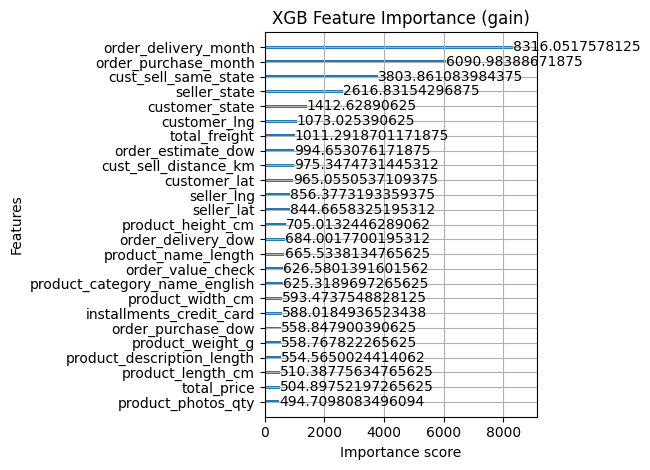

In [62]:
# Best fitted model from the search
best_model = xgb25vars_RS["search"].best_estimator_

# If X25_train is a DataFrame, use its column names
feature_names = list(X25_train.columns)

# Plot (gain = usually most informative)

ax = xgb.plot_importance(
    best_model,
    importance_type="gain",
    max_num_features=25
)
plt.title("XGB Feature Importance (gain)")
plt.tight_layout()
plt.show()

Now, let's take the most important 5 features and run our model again to see if performance improves

In [ ]:
best_model = xgb25vars_RS["search"].best_estimator_ # best model
feature_names = list(X25_train.columns) # our feature names

gain = best_model.get_booster().get_score(importance_type="gain") # select by gain
gain_s = pd.Series(gain).sort_values(ascending=False)

## If keys are already real column names, use them directly; otherwise map f0->colname
if set(gain_s.index).issubset(set(feature_names)):
    top5_feats = gain_s.head(5).index.tolist()
else:
    name_map = {f"f{i}": col for i, col in enumerate(feature_names)}
    top5_feats = [name_map[k] for k in gain_s.head(5).index if k in name_map] # select 5 best
###

# (extra safety) keep only columns that exist in X
top5_feats = [c for c in top5_feats if c in X25_train.columns]

print("Top 5 features by gain:", top5_feats)

X25_train_top5 = X25_train[top5_feats].copy()
X25_test_top5  = X25_test[top5_feats].copy()

X25_train_top5.info()
X25_test_top5.info()

Top 5 features by gain: ['order_delivery_month', 'order_purchase_month', 'cust_sell_same_state', 'seller_state', 'customer_state']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   order_delivery_month  73180 non-null  int64
 1   order_purchase_month  73180 non-null  int64
 2   cust_sell_same_state  73180 non-null  int64
 3   seller_state          73180 non-null  int64
 4   customer_state        73180 non-null  int64
dtypes: int64(5)
memory usage: 2.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   order_delivery_month  18295 non-null  int64
 1   order_purchase_month  18295 non-null  int64
 2   cust_sell_same_state  18295 non-null  int64
 3   seller_state          

In [59]:
xgb25_top5vars_RS = cv_my_random_xgb(
    X25_train_top5, y_train, X25_test_top5, y_test,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    show_results=True
)

Best params: {'colsample_bytree': np.float64(0.9237444621914055), 'gamma': np.float64(0.11146849061504398), 'learning_rate': np.float64(0.13430342707628237), 'max_depth': 6, 'min_child_weight': np.float64(0.7280452372541563), 'reg_alpha': np.float64(1.1134321697373643e-08), 'reg_lambda': np.float64(9.010706298964356), 'subsample': np.float64(0.6777095814048169)}
Best CV RMSE: 7.764599375989391
TEST RMSE: 7.681613472089153
TEST MAE: 5.538336743921424
TEST R²: 0.4495276543675798
Elapsed time: 71.82 seconds


In [60]:
xgb25vars_RS["rmse"] # test rmse

np.float64(7.3346493196987765)

`This is far worse. Let's stick to xgb25vars_RS`

We could also look at FI by *weight* ([”weight” is the number of times a feature appears in a tree](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn))

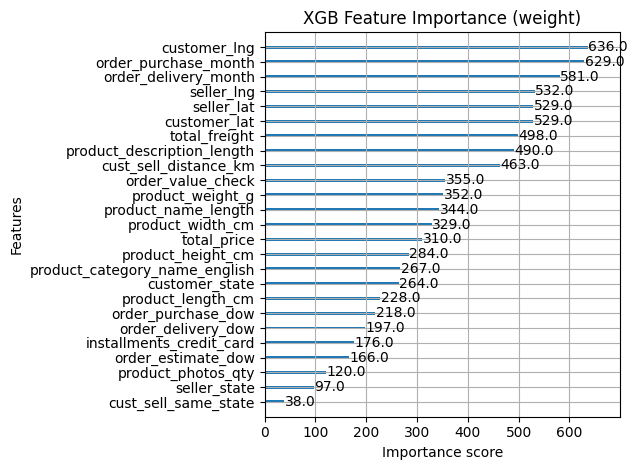

In [64]:
# Best fitted model from the search
best_model = xgb25vars_RS["search"].best_estimator_

# If X25_train is a DataFrame, use its column names
feature_names = list(X25_train.columns)

# Plot (gain = usually most informative)

ax = xgb.plot_importance(
    best_model,
    importance_type="weight",
    max_num_features=25
)
plt.title("XGB Feature Importance (weight)")
plt.tight_layout()
plt.show()

Let's try the 9 best features

In [66]:
best_model = xgb25vars_RS["search"].best_estimator_ # best model
feature_names = list(X25_train.columns) # our feature names

gain = best_model.get_booster().get_score(importance_type="weight") # select by WEIGHT THIS TIME
gain_s = pd.Series(gain).sort_values(ascending=False)

## If keys are already real column names, use them directly; otherwise map f0->colname
if set(gain_s.index).issubset(set(feature_names)):
    top9_feats = gain_s.head(9).index.tolist()
else:
    name_map = {f"f{i}": col for i, col in enumerate(feature_names)}
    top9_feats = [name_map[k] for k in gain_s.head(9).index if k in name_map] # select __9__ best
###

# (extra safety) keep only columns that exist in X
top9_feats = [c for c in top9_feats if c in X25_train.columns]

print("Top 5 features by gain:", top9_feats)

X25_train_top9 = X25_train[top9_feats].copy()
X25_test_top9  = X25_test[top9_feats].copy()

X25_train_top9.info()
X25_test_top9.info()

Top 5 features by gain: ['customer_lng', 'order_purchase_month', 'order_delivery_month', 'seller_lng', 'customer_lat', 'seller_lat', 'total_freight', 'product_description_length', 'cust_sell_distance_km']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_lng                73180 non-null  float64
 1   order_purchase_month        73180 non-null  int64  
 2   order_delivery_month        73180 non-null  int64  
 3   seller_lng                  73180 non-null  float64
 4   customer_lat                73180 non-null  float64
 5   seller_lat                  73180 non-null  float64
 6   total_freight               73180 non-null  float64
 7   product_description_length  73180 non-null  float64
 8   cust_sell_distance_km       73180 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 5.0 MB
<class 'pa

In [67]:
xgb25_top9vars_RS = cv_my_random_xgb(
    X25_train_top9, y_train, X25_test_top9, y_test,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    show_results=True
)

Best params: {'colsample_bytree': np.float64(0.7396838298450643), 'gamma': np.float64(0.02065697267209068), 'learning_rate': np.float64(0.14694924450340516), 'max_depth': 9, 'min_child_weight': np.float64(3.2209668757412535), 'reg_alpha': np.float64(0.9770817213609811), 'reg_lambda': np.float64(25.166736492345343), 'subsample': np.float64(0.9742539976883791)}
Best CV RMSE: 7.491246685253911
TEST RMSE: 7.334105466658132
TEST MAE: 5.174931152897675
TEST R²: 0.49820664335270204
Elapsed time: 88.10 seconds


In [68]:
xgb25vars_RS["rmse"] # test rmse

np.float64(7.3346493196987765)

In [71]:
xgb25_top9vars_RS["rmse"] < xgb25vars_RS["rmse"] # the lower the better of course

np.True_

> **This one seems to be better! Let's choose it as our best model!**

## Early stopping and boosting rounds

We can use native XGBoost API to fine-tune the number of bosoting rounds and implement early stopping

Best num_boost_round: 372
Best CV RMSE (test): 7.356873940995264


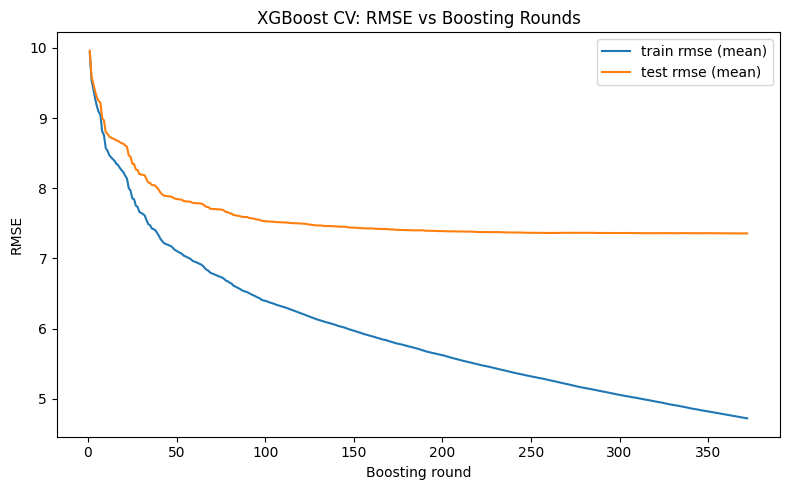

In [74]:
# ----------------------------
# 1) Grab best params from your RandomizedSearch run
# ----------------------------
best_params = xgb25_top9vars_RS["search"].best_params_

# ----------------------------
# 2) Build DMatrix (native XGBoost data structure)
# ----------------------------
X_tr = np.asarray(X25_train_top9)
y_tr = np.asarray(y_train).ravel()
dtrain = xgb.DMatrix(X_tr, label=y_tr)

# ----------------------------
# 3) Convert sklearn-style names to native XGBoost param names (safe)
# ----------------------------
params = dict(best_params)  # copy

if "learning_rate" in params:
    params["eta"] = params.pop("learning_rate")
if "reg_alpha" in params:
    params["alpha"] = params.pop("reg_alpha")
if "reg_lambda" in params:
    params["lambda"] = params.pop("reg_lambda")

# Required native params
params.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "verbosity": 0,
    "tree_method": "hist",
})

# ----------------------------
# 4) Native CV with early stopping to find best boosting rounds
# ----------------------------
cv_folds = 5
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
folds = list(kf.split(X_tr))

num_boost_round = 10_000  # we probably won't get that far
early_stopping_rounds = 50 # without improvement is a decent idea

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    folds=folds,
    early_stopping_rounds=early_stopping_rounds,
    seed=42,
    verbose_eval=False,
    as_pandas=True
)

best_round = int(cv_results["test-rmse-mean"].idxmin() + 1)
best_rmse = float(cv_results["test-rmse-mean"].min())

print("Best num_boost_round:", best_round)
print("Best CV RMSE (test):", best_rmse)

# ----------------------------
# 5) Plot loss (RMSE) vs boosting rounds
# ----------------------------
rounds = np.arange(1, len(cv_results) + 1)

plt.figure(figsize=(8, 5))
plt.plot(rounds, cv_results["train-rmse-mean"], label="train rmse (mean)")
plt.plot(rounds, cv_results["test-rmse-mean"], label="test rmse (mean)")
plt.xlabel("Boosting round")
plt.ylabel("RMSE")
plt.title("XGBoost CV: RMSE vs Boosting Rounds")
plt.legend()
plt.tight_layout()
plt.show()


Let's refit the final model (with the selected number of boosting rounds)

In [ ]:
# --- 4) Refit final sklearn-style model using best_round and evaluate on test ---
# Convert numpy scalars in best_params to plain Python types (safe)
best_params_clean = {k: (v.item() if hasattr(v, "item") else v) for k, v in best_params.items()} # using our best models params from CV

final_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=best_round,
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    verbosity=0,
    **best_params_clean
)

final_model.fit(X25_train_top9, y_train)

y_pred = final_model.predict(X25_test_top9)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test  = mean_absolute_error(y_test, y_pred)
r2_test   = r2_score(y_test, y_pred)

print("FINAL TEST RMSE:", rmse_test)
print("FINAL TEST MAE:", mae_test)
print("FINAL TEST R²:", r2_test)

FINAL TEST RMSE: 7.1460760826037015
FINAL TEST MAE: 5.1073064753338775
FINAL TEST R²: 0.5236064456213878


> **There is noticeable improvement from our first models!!**

# Saving the best XGBoost model

In [ ]:
 # Save the final trained model as a pickle file

model_path = "5.models/xgb25_top9_final_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(final_model, f)

print("Saved final model to:", model_path)

Saved final model to: 5.models/xgb25_top9_final_model.pkl


In [80]:
X25_train_top9.to_pickle("6.data_cache/X25_train_top9.pkl")
X25_test_top9.to_pickle("6.data_cache/X25_test_top9.pkl")

y_train.to_pickle("6.data_cache/y_train.pkl")
y_test.to_pickle("6.data_cache/y_test.pkl")